# **TASK 3: Handwritten Character Recognition**
**Objective:**
Identify handwritten characters or alphabets.

**Approach:** Use image processing and deep learning.

**Key Features:**

● Dataset: MNIST (digits), EMNIST (characters).

● Model: Convolutional Neural Networks (CNN).

● Extendable to full word or sentence recognition with sequence modeling (like CRNN).

In [47]:
# Install tensorflow_datasets
!pip install tensorflow_datasets

# Import libraries
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [48]:
# Load EMNIST Letters Dataset
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [49]:
# Normalize & reshape
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, -1)  # Add channel dimension
    label -= 1  # Convert from 1–26 to 0–25
    return image, label

ds_train = ds_train.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(128).prefetch(tf.data.AUTOTUNE)


In [50]:
# Define CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(26, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
model.fit(ds_train, epochs=5, validation_data=ds_test)


Epoch 1/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.5469 - loss: 1.5254 - val_accuracy: 0.8716 - val_loss: 0.3869
Epoch 2/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8301 - loss: 0.5351 - val_accuracy: 0.8928 - val_loss: 0.3264
Epoch 3/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8630 - loss: 0.4297 - val_accuracy: 0.9037 - val_loss: 0.2844
Epoch 4/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8797 - loss: 0.3739 - val_accuracy: 0.9107 - val_loss: 0.2644
Epoch 5/5
694/694 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8896 - loss: 0.3390 - val_accuracy: 0.9122 - val_loss: 0.2584


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


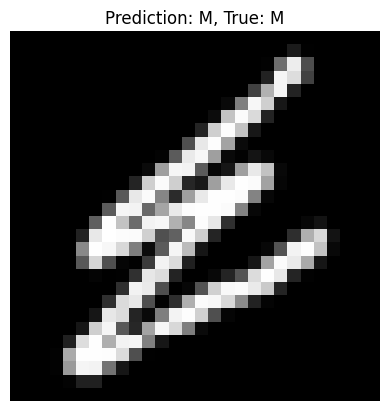

In [51]:
# Show prediction
for images, labels in ds_test.take(1):
    image = images[0]
    true_label = labels[0].numpy()
    pred = model.predict(tf.expand_dims(image, 0))
    pred_label = np.argmax(pred)

    plt.imshow(tf.squeeze(image), cmap='gray')
    plt.title(f"Prediction: {chr(pred_label + 65)}, True: {chr(true_label + 65)}")
    plt.axis('off')
    plt.show()


In [52]:
# Save the Model
model.save("emnist_letters_model_tfds.h5")


# **Extendable to full word or sentence recognition with sequence modeling (like CRNN).**

In [21]:
import tensorflow as tf
from tensorflow.keras import layers
import os

In [53]:
characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
char_to_num = layers.StringLookup(vocabulary=list(characters), oov_token="*")
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

In [54]:
def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.resize(image, [32, 128])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def prepare_dataset(images_dir, labels_file):
    lines = tf.io.read_file(labels_file).numpy().decode().split("\n")
    records = [line.split() for line in lines if len(line.strip().split()) >= 2]
    paths = [os.path.join(images_dir, r[0]) for r in records]
    texts = [r[1] for r in records]

    labels = [char_to_num(tf.strings.unicode_split(t, input_encoding="UTF-8")) for t in texts]

    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [55]:
def ctc_loss_fn(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)


In [56]:
inputs = tf.keras.Input(shape=(32, 128, 1))

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,1))(x)

new_shape = x.shape
x = layers.Reshape((new_shape[1], new_shape[2] * new_shape[3]))(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

vocab_size = len(char_to_num.get_vocabulary()) + 1  # CTC blank token
outputs = layers.Dense(vocab_size, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss=ctc_loss_fn)

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 4, 8192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 4, 256)         │     8,520,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 4, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4, 64)          │        16,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,302,080 (35.48 MB)

 Trainable params: 9,301,568 (35.48 MB)

 Non-trainable params: 512 (2.00 KB)

In [41]:
model.compile(optimizer="adam", loss=ctc_loss_fn)

In [61]:
# Character Mapping Utilities
from tensorflow.keras import layers
characters = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

# Create lookup tables
char_to_num = layers.StringLookup(vocabulary=list(characters), oov_token="*")
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

In [62]:
# Image Processing Functions
import os

# Process a single image
def process_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.resize(image, [32, 128])  # Resize for CRNN
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Build full dataset pipeline
def prepare_dataset(images_dir, labels_file):
    lines = tf.io.read_file(labels_file).numpy().decode().split("\n")
    records = [line.split() for line in lines if len(line.strip().split()) >= 2]
    paths = [os.path.join(images_dir, r[0]) for r in records]
    texts = [r[1] for r in records]

    # Encode characters as integers
    labels = [char_to_num(tf.strings.unicode_split(t, input_encoding="UTF-8")) for t in texts]

    # Create tf.data.Dataset
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(32).prefetch(tf.data.AUTOTUNE)


In [63]:
# Define CTC Loss Function
def ctc_loss_fn(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)


In [64]:
# Build the CRNN Model
inputs = tf.keras.Input(shape=(32, 128, 1))

# Convolutional layers
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2,1))(x)

# Reshape for RNN
x = layers.Reshape((x.shape[1], x.shape[2]*x.shape[3]))(x)

# Recurrent layers (BiLSTM)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

# Output layer with softmax
vocab_size = len(char_to_num.get_vocabulary()) + 1  # +1 for blank token
outputs = layers.Dense(vocab_size, activation='softmax')(x)

# Final model
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss=ctc_loss_fn)

model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 128, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 4, 8192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 4, 256)         │     8,520,704 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 4, 256)         │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4, 64)          │        16,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,302,080 (35.48 MB)

 Trainable params: 9,301,568 (35.48 MB)

 Non-trainable params: 512 (2.00 KB)

# **Summary:**
Part 1 is suitable for recognizing isolated characters using CNN.

Part 2 extends to sequence prediction like full words using CRNN + CTC Loss.